# Load the Visium dataset in scanpy/squidpy

In [2]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image

# Define paths to the files
base_path = "/Users/rabbit/Downloads/perturbmap cc/base_folder/GSM5808054_KP_1/"
matrix_file = base_path + "GSM5808054_KP_1_filtered_feature_bc_matrix.h5"
positions_file = base_path + "spatial/tissue_positions_list.csv"
annotation_file= base_path + "spatial/spot_annotation.csv"
scalefactors_file = base_path + "spatial/scalefactors_json.json"
hires_image_path = base_path + "spatial/tissue_hires_image.png"
lowres_image_path = base_path + "spatial/tissue_lowres_image.png"

# Load the expression matrix
adata = sc.read_10x_h5(matrix_file)

# Load spatial coordinates
positions = pd.read_csv(positions_file, header=None)
positions.columns = ['barcode', 'in_tissue', 'array_row', 'array_col', 'X_coordinate', 'Y_coordinate']
positions.set_index('barcode', inplace=True)

# Join the spatial coordinates with the AnnData object
adata.obs = adata.obs.join(positions, how='left')

/Users/rabbit/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/rabbit/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
# Filter positions to only include entries with barcodes present in adata.obs and in_tissue equal to 1
positions_filtered = positions.loc[positions['in_tissue'] == 1]

# Check the new shape of positions_filtered
print("Filtered positions entries:", positions_filtered.shape[0])

# Assign to adata.obsm 
positions_filtered.shape[0] == adata.obs.shape[0]
adata.obsm['spatial'] = positions_filtered[['X_coordinate', 'Y_coordinate']].to_numpy()


# Check the structure of the array to be assigned to adata.obsm
array_to_assign = positions_filtered[['X_coordinate', 'Y_coordinate']].to_numpy()
print("Shape of the array to assign:", array_to_assign.shape)


Filtered positions entries: 1906
Shape of the array to assign: (1906, 2)


In [4]:
# Load scale factors
with open(scalefactors_file, 'r') as f:
    scalefactors = json.load(f)

# Store scalefactors and image paths in the uns structure of AnnData
adata.uns['spatial'] = {
    'scalefactors': scalefactors,
    'images': {
        'hires': hires_image_path,
        'lowres': lowres_image_path
    }
}

In [5]:
# Load the images
hires_image = Image.open(hires_image_path)
lowres_image = Image.open(lowres_image_path)

# Validate that they are correctly loaded
print("High-resolution image size:", hires_image.size)
print("Low-resolution image size:", lowres_image.size)

# Convert images to numpy arrays
hires_image_np = np.array(hires_image)
lowres_image_np = np.array(lowres_image)

High-resolution image size: (2000, 1952)
Low-resolution image size: (600, 586)


In [6]:
# Ensure the spatial structure includes a library ID
library_id = "GSM5808054_KP_1"
adata.uns['spatial'] = {
    library_id: {
        'scalefactors': scalefactors,
        'images': {
            'hires': hires_image_np,
            'lowres': lowres_image_np
        }
    }
}

In [23]:
# Load the spot annotation file
annotation_df = pd.read_csv(annotation_file)

# Ensure the barcodes align
annotation_df.set_index('barcode', inplace=True)

# Join the annotation DataFrame with adata.obs
adata.obs = adata.obs.join(annotation_df, how='left', rsuffix='_new')
# adata.obs = adata.obs.join(annotation_df, how='left')


In [24]:
adata

AnnData object with n_obs × n_vars = 1906 × 32289
    obs: 'in_tissue', 'array_row', 'array_col', 'X_coordinate', 'Y_coordinate', 'nCount_Spatial', 'nFeature_Spatial', 'kmeans', 'leiden_clusters', 'phenotypes', 'nCount_Spatial_new', 'nFeature_Spatial_new', 'kmeans_new', 'leiden_clusters_new', 'phenotypes_new', 'nCount_Spatial_new', 'nFeature_Spatial_new', 'kmeans_new', 'leiden_clusters_new', 'phenotypes_new'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'kmeans_colors', 'phenotypes_colors', 'spot_annotations'
    obsm: 'spatial'

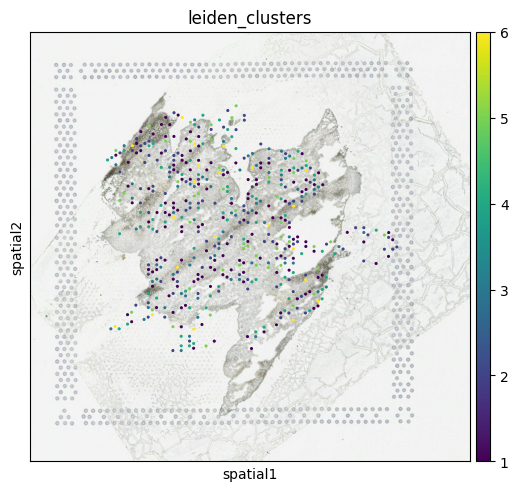

In [27]:
# Plot a specific gene expression overlaid on the high-resolution tissue image
sq.pl.spatial_scatter(adata, color=['leiden_clusters'], spatial_key='spatial')

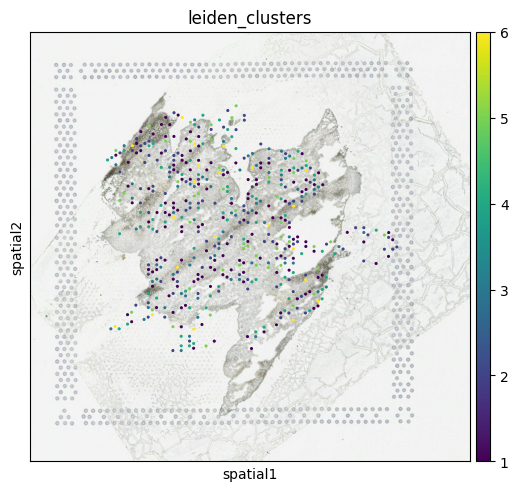

In [30]:
# Plot a specific gene expression overlaid on the high-resolution tissue image
sq.pl.spatial_scatter(adata, color=['leiden_clusters'], spatial_key='spatial')

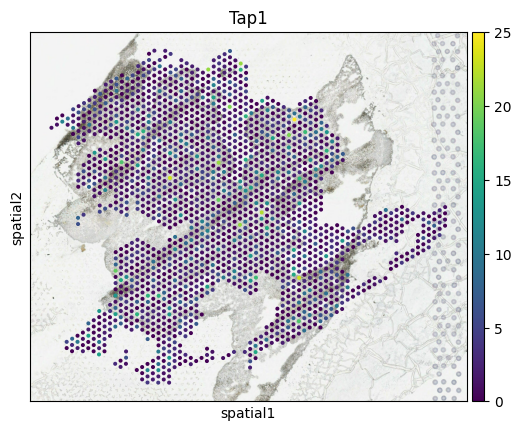

In [10]:
sc.pl.spatial(adata, color=['Tap1'])

/Users/rabbit/Library/Python/3.9/lib/python/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


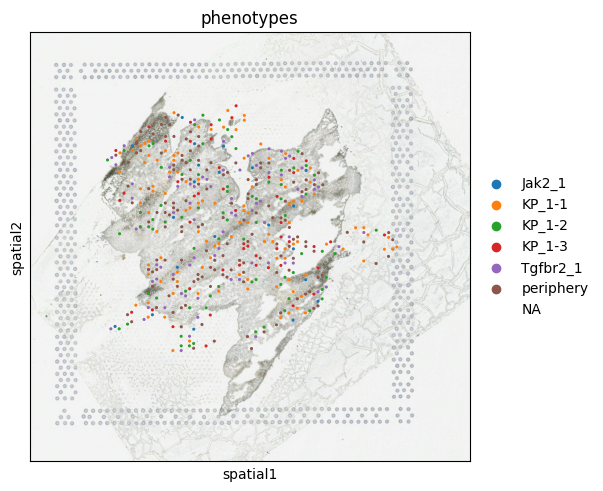

In [12]:
sq.pl.spatial_scatter(adata, color=['phenotypes'])